In [1]:
from pathlib import Path
import seaborn as sns

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import h5py


## Load

In [99]:
# DATASET_NAME = 'set_01'
DATASET_NAME = 'exp_17'
# DATASET_NAME = 'set_03'

TRACES_ROOT = Path('trace_data')

TRACES_PATH = TRACES_ROOT / DATASET_NAME

In [102]:
def load_trace_dir(in_path: Path):
    traces = {}
    for hdf5_path in sorted(in_path.glob('*.h5')):
        print(f'loading {hdf5_path}  ->  {hdf5_path.stem}')
        traces[hdf5_path.stem] = h5py.File(hdf5_path)
    
    return traces


hdf5_traces = load_trace_dir(TRACES_PATH)

loading trace_data/exp_17/F6_2_post.000_cropped_filtered_17june.analysis.h5  ->  F6_2_post.000_cropped_filtered_17june.analysis
loading trace_data/exp_17/F6_2_pre.000_cropped_filtered_17june.analysis.h5  ->  F6_2_pre.000_cropped_filtered_17june.analysis
loading trace_data/exp_17/F6_2_stimulus.000_cropped_filtered_17june.analysis.h5  ->  F6_2_stimulus.000_cropped_filtered_17june.analysis


## Process

In [103]:
PROCESS_ALL_TRACES = True
# PROCESS_ALL_TRACES = False

PROCESS_ONLY_TRACES = [
    'F10_1_stimulus',
    # 'F10_3_stimulus',
]


FRAMERATE = 12.5
PIXELS_TO_MM =  400 / 1200.0

LAMP_LOCATION = 'right'
# LAMP_LOCATION = 'left'


assert LAMP_LOCATION in ['left', 'right']


In [104]:
def unpack_traces(hdf5_handle, verbose=True):
    node_names = [name.decode() for name in hdf5_handle['node_names'][:]]
    track_names = [name.decode() for name in hdf5_handle['track_names'][:]]
    tracks = hdf5_handle['tracks'][:].T

    if verbose:
        print(f'nodes:       {node_names}')
        print(f'track names: {track_names}')
        print(f'track data  {tracks.shape}')
        print(f'  frames    {tracks.shape[0]}')
        print(f'  nodes     {tracks.shape[1]}')
        print(f'  animals   {tracks.shape[3]}')

    return tracks, track_names, node_names


def tracks_to_dataframe(tracks, track_names, node_index=0, drop_na=True):
    track_df_list = []
    for i, name in enumerate(track_names):
        track_df = pd.DataFrame(
            {
                'track_name': name,
                'frame': np.arange(tracks.shape[0]),
                'x': tracks[:, node_index, 0, i],
                'y': tracks[:, node_index, 1, i],
            }
        )
        if drop_na:
            track_df = track_df.dropna(subset=['x', 'y'], ignore_index=True)
        track_df['x_diff'] = track_df['x'].diff()
        track_df['y_diff'] = track_df['y'].diff()
        track_df['frame_diff'] = track_df['frame'].diff()
        
        track_df['x_translation'] = track_df['x'].iloc[-1] - track_df['x'].iloc[0]
        track_df['y_translation'] = track_df['y'].iloc[-1] - track_df['y'].iloc[0]

        track_df_list.append(track_df)

    return pd.concat(track_df_list, ignore_index=True)


def process_track_df(track_df, lamp_location: str, framerate: float, pixels_to_mm: float):
    track_proc_df = track_df.copy()
    
    if lamp_location == 'left':
        track_proc_df['x_translation']  = -track_proc_df['x_translation'] 
    track_proc_df['x_translation_mm'] = track_proc_df['x_translation'] * pixels_to_mm
    track_proc_df['y_translation_mm'] = track_proc_df['y_translation'] * pixels_to_mm
    
    track_proc_df['speed'] = np.sqrt(track_proc_df['x_diff'].pow(2) + track_proc_df['y_diff'].pow(2)) / track_proc_df['frame_diff']
    track_proc_df['speed_mm_s'] = track_proc_df['speed'] * pixels_to_mm * framerate
    
    return track_proc_df


def process_hdf5_traces(traces, limit_trace_names=None):
    process_all = True
    if limit_trace_names:
        limit_trace_names = set(limit_trace_names)
        process_all = False
        
    track_df_map = {}
    for trace_name in traces:
        if not process_all and trace_name not in limit_trace_names:
            continue
            
        print(f'processing {trace_name}')
        tracks, track_names, node_names = unpack_traces(traces[trace_name])
        
        track_df = tracks_to_dataframe(tracks, track_names, drop_na=True)
        track_proc_df = process_track_df(track_df, LAMP_LOCATION, FRAMERATE, PIXELS_TO_MM)
        track_df_map[trace_name] = track_proc_df
        print('')
    
    return track_df_map


In [105]:
if PROCESS_ALL_TRACES:
    track_dfs = process_hdf5_traces(hdf5_traces)
else:
    track_dfs = process_hdf5_traces(hdf5_traces, PROCESS_ONLY_TRACES)

out_path = Path(f'./out/{DATASET_NAME}/')
out_path_png = out_path / 'png'
out_path.mkdir(parents=True, exist_ok=True)
out_path_png.mkdir(parents=True, exist_ok=True)

for df_name, track_df in track_dfs.items():
    track_df.to_csv(f'{out_path}/{df_name}.csv', header=True, index=False)


processing F6_2_post.000_cropped_filtered_17june.analysis
nodes:       ['head', 'tail', 'l_antenna', 'r_antenna']
track names: ['track_1', 'track_2', 'track_3', 'track_4', 'track_5', 'track_6', 'track_7', 'track_8', 'track_9', 'track_10']
track data  (67509, 4, 2, 10)
  frames    67509
  nodes     4
  animals   10

processing F6_2_pre.000_cropped_filtered_17june.analysis
nodes:       ['head', 'tail', 'l_antenna', 'r_antenna']
track names: ['track_1', 'track_2', 'track_3', 'track_4', 'track_5', 'track_6', 'track_7', 'track_8', 'track_9', 'track_10']
track data  (67032, 4, 2, 10)
  frames    67032
  nodes     4
  animals   10

processing F6_2_stimulus.000_cropped_filtered_17june.analysis
nodes:       ['head', 'tail', 'l_antenna', 'r_antenna']
track names: ['track_1', 'track_10', 'track_2', 'track_3', 'track_4', 'track_5', 'track_6', 'track_7', 'track_8', 'track_9']
track data  (67250, 4, 2, 10)
  frames    67250
  nodes     4
  animals   10



In [106]:
# track_dfs['F10_1_post']
# track_dfs.keys()

## Plot

In [107]:
sns.set_theme()

def plot_traces(tracks_df, name):
    fig = plt.figure(figsize=(16, 8), dpi=75)
    
    ax = sns.lineplot(data=tracks_df, x='x', y='y', hue='track_name', alpha=0.7, lw=2, sort=False)
    ax_scatter = sns.scatterplot(data=tracks_df, x='x', y='y', hue='track_name', alpha=0.7, size='speed', sizes=(10.0, 200.0), legend=False)
    
    ax.set_xlim(0, 1361)
    ax.set_ylim(0, 620)
    ax.invert_yaxis()
    
    ax.set_title(f'Trace plot, {name}')
    
    plt.legend(loc=1, fontsize=9)
    
    fig.tight_layout()
    fig.savefig(f'{out_path_png}/{name}_traces.png')
    plt.show()


def plot_mean_speed(tracks_df, name):
    plt.figure(figsize=(15, 6), dpi=75)

    tracks_df_mean = tracks_df[['track_name', 'x', 'speed']].groupby('track_name').mean()
    
    ax = sns.barplot(data=tracks_df_mean, x="track_name", y="speed", hue='track_name')
    ax.set_title(f'Mean speed, {name}')
    
    plt.tight_layout()
    plt.show()
    

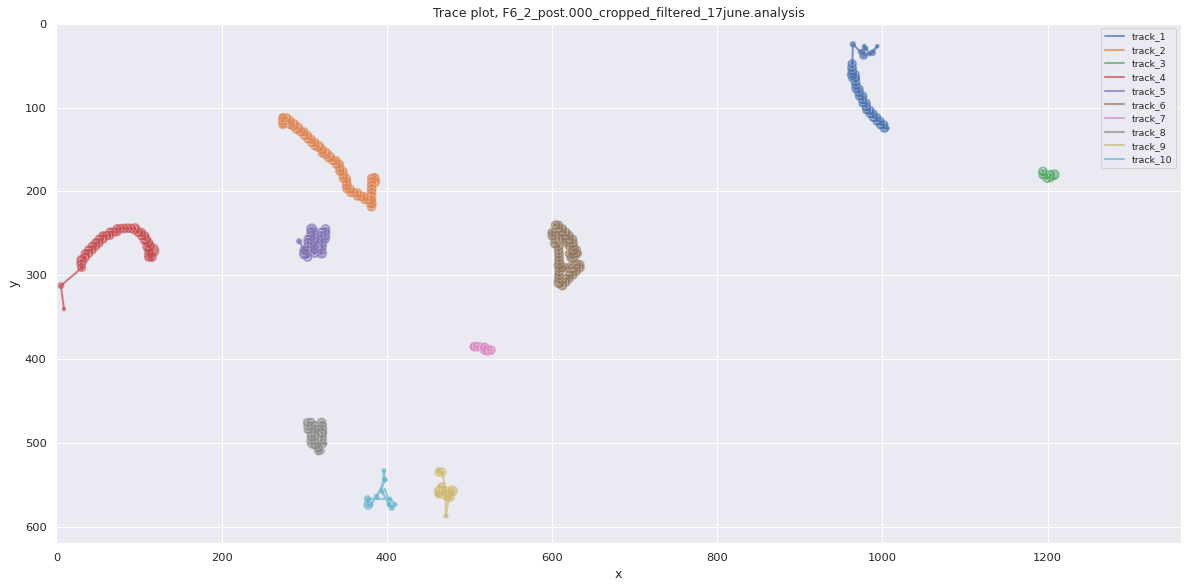

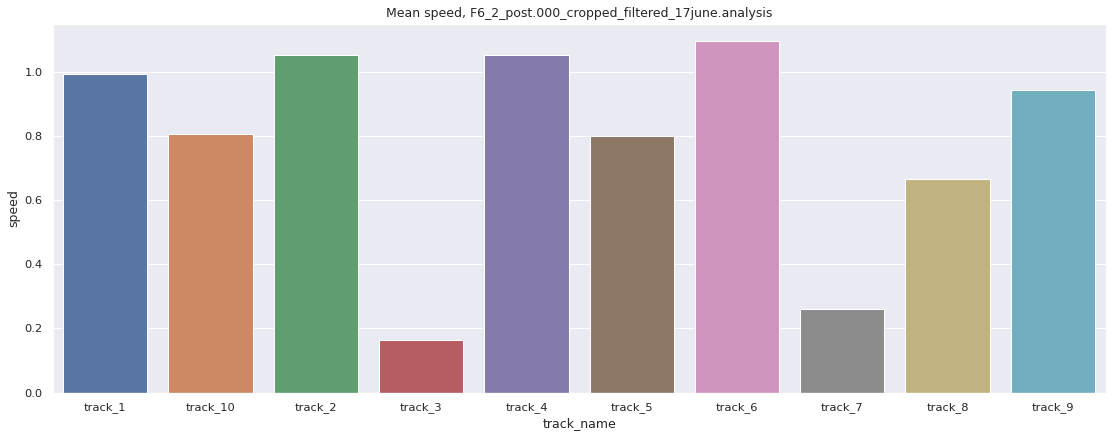

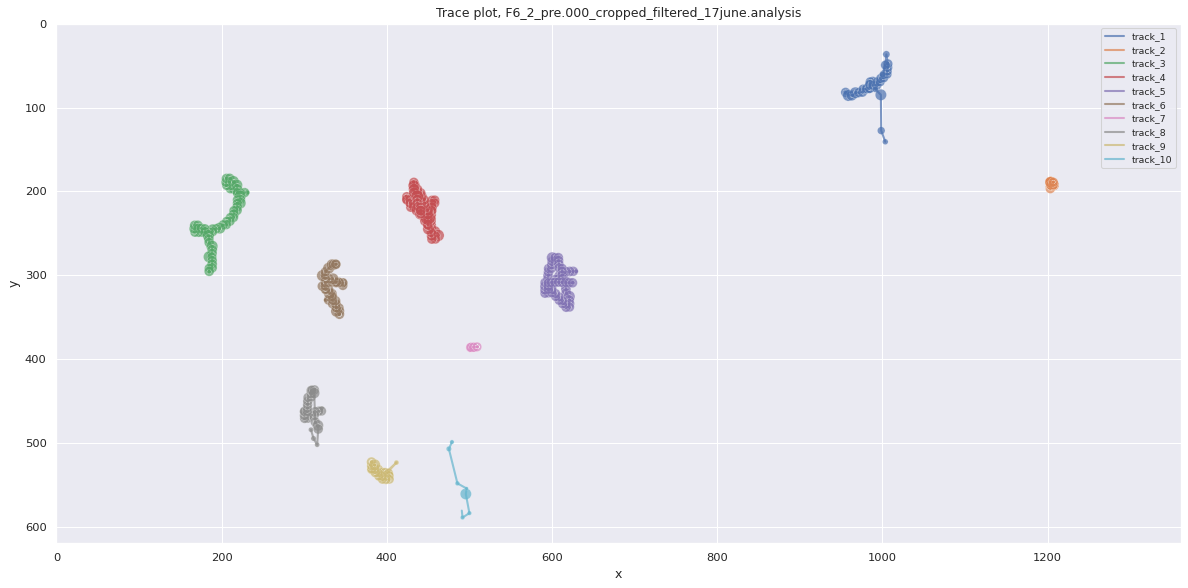

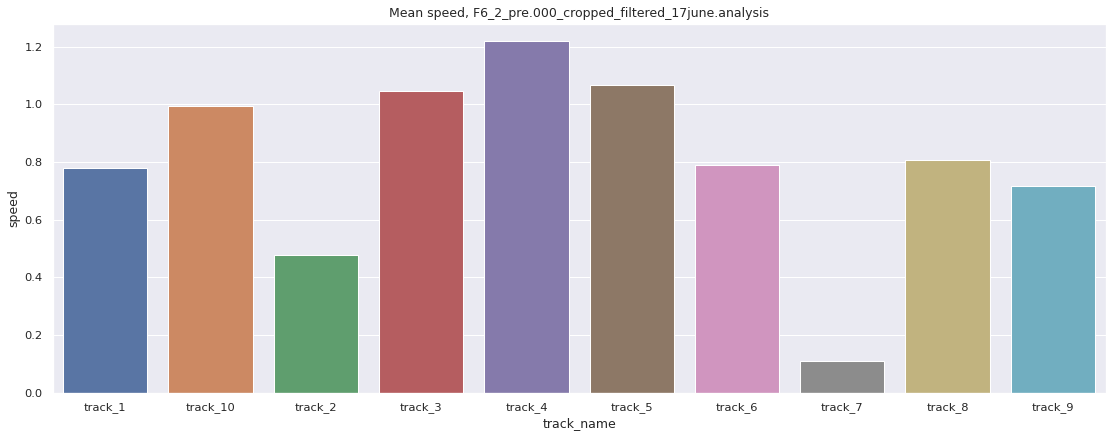

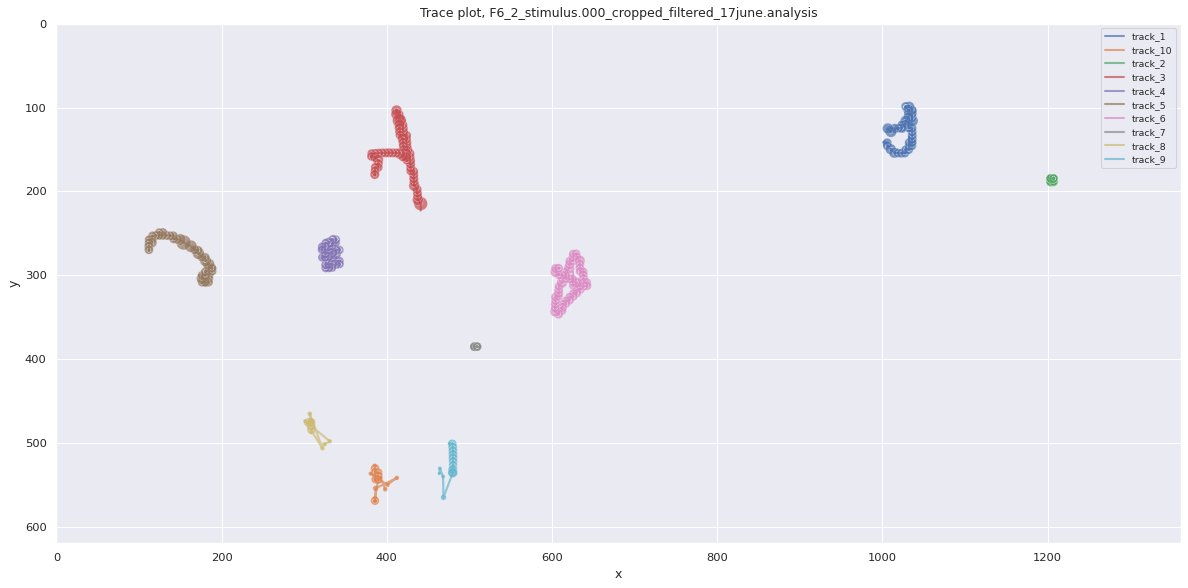

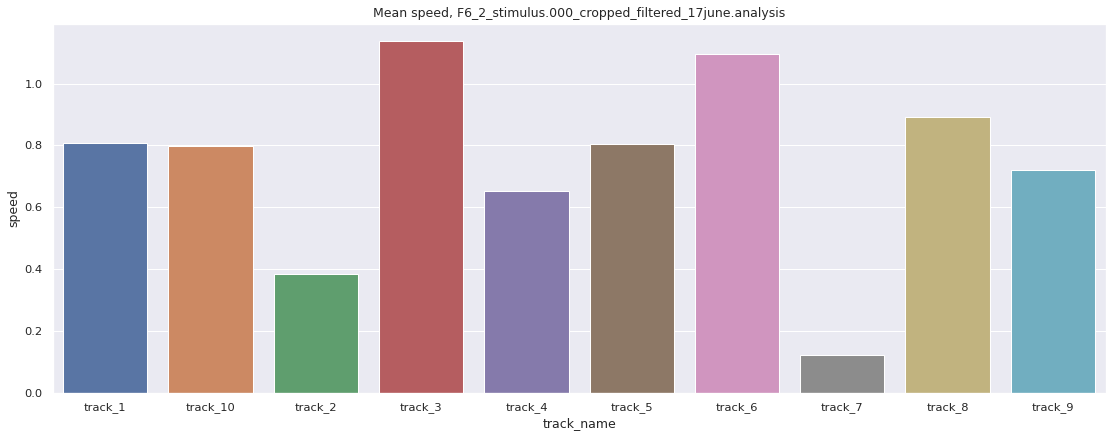

In [108]:
for df_name, track_df in track_dfs.items():
    plot_traces(track_df, df_name)
    plot_mean_speed(track_df, df_name)
